# Описание эксперимента

Есть несколько наборов данных:
- metlin_8_25 - часть набора данных METLIN со значениями времени удерживания от 8 до 25 - самый большой набо данных (77889 строк)
- metlin_0_8 - часть набора данных METLIN со значениями времени удерживания от 0 до 8 (2068 строк)
- hilic - набор данных, собранных в другой лаборатории, время удерживания от 0 до 10 (880 строк)
- hilic_oxana - набор данных, собранный в третьей лаборатории (18 строк)

Задача:
обучить нейронную сеть на самом большом наборе данных, дообучить на остальных наборах, и предсказать как можно более близкие значения для набора данных hilic_oxana.



# Подключение необходимых библиотек

In [7]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 13.6 MB/s eta 0:00:00


In [8]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 59.7 MB/s eta 0:00:00


In [9]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 6.4 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
import torch

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import xgboost

import lightgbm

import openpyxl
from openpyxl import load_workbook

from torch.utils.data import random_split

# Наборы данных

Загружаем уже подготовленные наборы данных, полученные из [METLIN](https://figshare.com/articles/dataset/The_METLIN_small_molecule_dataset_for_machine_learning-based_retention_time_prediction/8038913?file=18130628) и [HILIC]('https://pubs.acs.org/doi/abs/10.1021/acs.analchem.9b05765#').

Данные представляют собой две колонки:
- SMILES дополнены пробелами до длины 185 символов (максимальная длина строки для обоих наборов данных);
- RT (retention time) переведены в минуты.

In [11]:
metlin_0_8 = pd.read_csv('METLIN_0_8_to_OHE_to_CNN')
metlin_8_25 = pd.read_csv('METLIN_8_25_to_OHE_to_CNN')
hilic = pd.read_csv('HILIC_to_OHE_to_CNN')
metlin = pd.read_csv('METLIN_to_OHE_to_CNN')
hilic_oxana = pd.read_csv('HILIC_OXANA_to_OHE_to_CNN')

In [12]:
metlin_0_8

,smiles,rt
0,CCSC(=N)N ...,1.558333
1,CCN1CCc2[nH]c(=N)oc2CC1 ...,1.328333
2,CN1CCC(c2c[nH]c3ccc(O)cc23)CC1 ...,1.570000
3,N[C@H]1CCc2cc(O)c(O)cc2C1 ...,1.525000
4,NNC(=O)c1ccc(O)cc1 ...,1.936667
...,...,...
2063,Cc1cnc(C(O)=N[C@@H]2CCC[C@@H]2C(O)=NC2CCN(C)CC...,1.398333
2064,CCC(=O)N1CCN([C@H]2CCN(CCN(C)C)C2=O)CC1 ...,1.315000
2065,Cc1oc2c(c1C(O)=NCCCn1cccn1)CN(C)CC2 ...,1.350000
2066,Cc1cnc(C(O)=N[C@@H]2CCC[C@@H]2C(O)=NCCN2CCOCC2...,1.365000


In [13]:
metlin_8_25

,smiles,rt
0,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,11.463333
1,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1O...,9.845000
2,Oc1cccc2c(O)nccc12 ...,9.726667
3,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1 ...,9.650000
4,CC(C)(C)NC[C@H](O)COc1cccc2nc(O)[nH]c12 ...,10.051667
...,...,...
77884,CCOc1ccc(OCC)c(NS(=O)(=O)c2ccc(/C=C/c3onc(C)c3...,15.773333
77885,COCCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(F)c3)C...,10.885000
77886,COCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(C)c3)C[...,10.803333
77887,Cc1ccc(S(=O)(=O)N2C[C@@H]3CN(C(O)=Nc4ccccc4C)C...,13.065000


In [14]:
hilic

,smiles,rt
0,C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O ...,2.019083
1,CC1C(NC(CN1)C2=CC=CC=C2)C ...,2.607950
2,C1CCC(C(C1)O)O ...,4.876550
3,C1CCC(=O)C(=O)C1 ...,5.772267
4,CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C ...,1.827733
...,...,...
875,CC1CC2=C(CCC(=O)C2)C3C1C4CCC(C4(CC3)C)(C#C)O ...,0.995283
876,C1=CC(=CC=C1C=CC2=CC(=CC(=C2)OC3C(C(C(C(O3)CO)...,4.640017
877,C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O...,9.717716
878,C1CC(=O)C(C=C1)(C(=O)OCC2=CC=CC=C2OC3C(C(C(C(O...,1.507783


In [15]:
hilic_oxana

,smiles,rt
0,C1=NC=NN1 ...,4.6
1,C1(=NC(=NN1)N)N ...,7.6
2,C1=NN=CN1N ...,6.8
3,CC1=NC=NN1 ...,5.2
4,C1=NNN=C1 ...,3.4
5,C1=NNC(=N1)N ...,5.6
6,C1=CNN=C1 ...,3.4
7,CC1=CC=NN1 ...,3.5
8,CN1C=CC(=N1)N ...,4.5
9,CCC1=CC(=NN1)N ...,4.3


Переведём все значения в секунды:

In [16]:
metlin_0_8.loc[:, 'rt'] = metlin_0_8['rt'].apply(lambda x: x * 60)
metlin_8_25.loc[:, 'rt'] = metlin_8_25['rt'].apply(lambda x: x * 60)
hilic.loc[:, 'rt'] = hilic['rt'].apply(lambda x: x * 60)
hilic_oxana.loc[:, 'rt'] = hilic_oxana['rt'].apply(lambda x: x * 60)

Посмотрим на распределение данных:

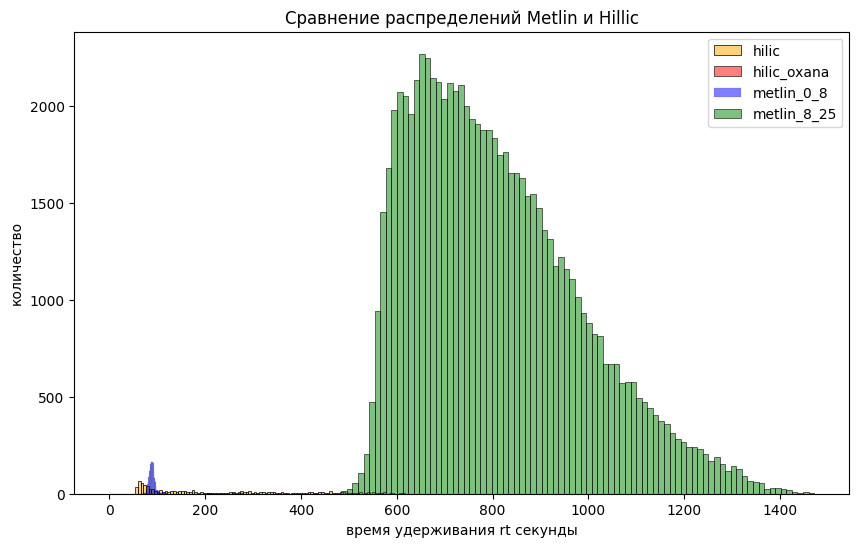

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

sns.histplot(hilic['rt'], label='hilic', color='orange', fill=True, alpha=0.5, bins=100)
sns.histplot(hilic_oxana['rt'], label='hilic_oxana', color='red', fill=True, alpha=0.5, bins=100)
sns.histplot(metlin_0_8['rt'], label='metlin_0_8', color='blue', fill=True, alpha=0.5)
sns.histplot(metlin_8_25['rt'], label='metlin_8_25', color='green', fill=True, alpha=0.5)

plt.title('Сравнение распределений Metlin и Hillic')
plt.xlabel('время удерживания rt секунды')
plt.ylabel('количество')

plt.legend()

plt.show()

## Преобразование Бокса-Кокса:

### Для набора данных metlin_8_25:

Параметр λ (lambda): -0.7251337687355247
Преобразованные данные: 
[1.36697658 1.3655672  1.3654484  ... 1.36644585 1.36806949 1.36577845]


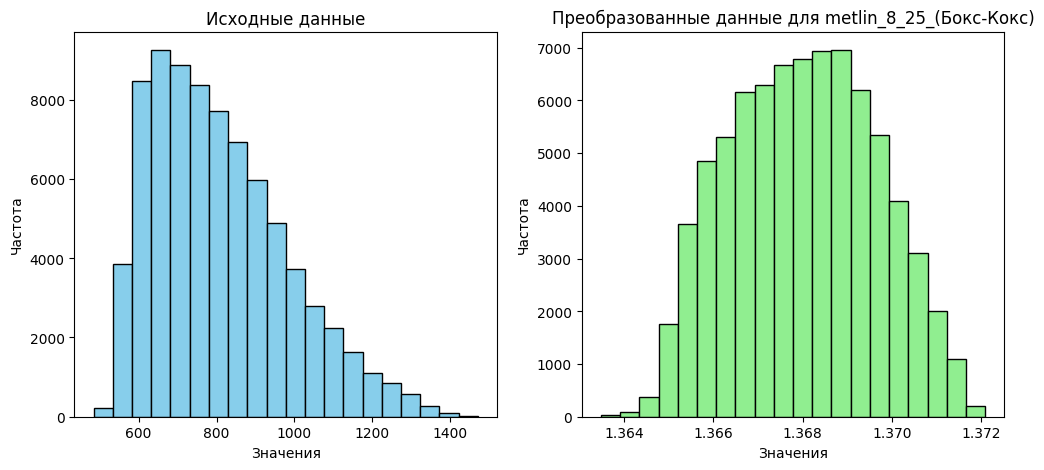

In [18]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

data_8_25 = metlin_8_25['rt']


tr_data_8_25, lambda_8_25 = stats.boxcox(data_8_25)

print(f'Параметр λ (lambda): {lambda_8_25}')
print('Преобразованные данные: ')
print(tr_data_8_25)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data_8_25, bins=20, color='skyblue', edgecolor='black')
plt.title('Исходные данные')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(tr_data_8_25, bins=20, color='lightgreen', edgecolor='black')
plt.title('Преобразованные данные для metlin_8_25_(Бокс-Кокс)')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.show()

In [19]:
metlin_8_25['rt'] = tr_data_8_25

In [20]:
metlin_8_25

,smiles,rt
0,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,1.366977
1,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1O...,1.365567
2,Oc1cccc2c(O)nccc12 ...,1.365448
3,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1 ...,1.365370
4,CC(C)(C)NC[C@H](O)COc1cccc2nc(O)[nH]c12 ...,1.365769
...,...,...
77884,CCOc1ccc(OCC)c(NS(=O)(=O)c2ccc(/C=C/c3onc(C)c3...,1.369472
77885,COCCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(F)c3)C...,1.366515
77886,COCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(C)c3)C[...,1.366446
77887,Cc1ccc(S(=O)(=O)N2C[C@@H]3CN(C(O)=Nc4ccccc4C)C...,1.368069


### Для набора данных metlin_0_8:

Параметр λ (lambda): 0.47642327251108774
Преобразованные данные: 
[16.13778052 14.8017781  16.20270047 ... 14.93255795 15.02245515
 14.84213623]


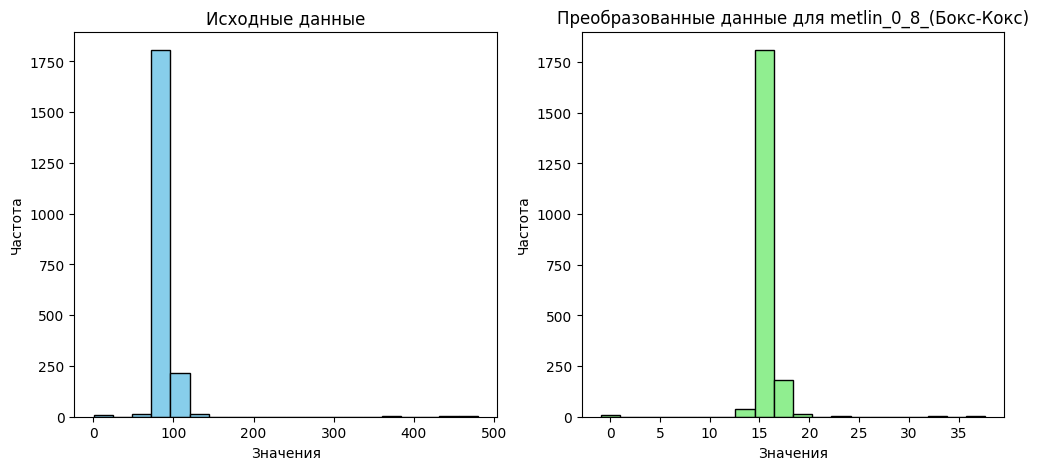

In [21]:
data_0_8 = metlin_0_8['rt']

tr_data_0_8, lambda_0_8 = stats.boxcox(data_0_8)

print(f'Параметр λ (lambda): {lambda_0_8}')
print('Преобразованные данные: ')
print(tr_data_0_8)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data_0_8, bins=20, color='skyblue', edgecolor='black')
plt.title('Исходные данные')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(tr_data_0_8, bins=20, color='lightgreen', edgecolor='black')
plt.title('Преобразованные данные для metlin_0_8_(Бокс-Кокс)')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.show()

In [22]:
metlin_0_8['rt'] = tr_data_0_8

In [23]:
metlin_0_8

,smiles,rt
0,CCSC(=N)N ...,16.137781
1,CCN1CCc2[nH]c(=N)oc2CC1 ...,14.801778
2,CN1CCC(c2c[nH]c3ccc(O)cc23)CC1 ...,16.202700
3,N[C@H]1CCc2cc(O)c(O)cc2C1 ...,15.950880
4,NNC(=O)c1ccc(O)cc1 ...,18.127459
...,...,...
2063,Cc1cnc(C(O)=N[C@@H]2CCC[C@@H]2C(O)=NC2CCN(C)CC...,15.220393
2064,CCC(=O)N1CCN([C@H]2CCN(CCN(C)C)C2=O)CC1 ...,14.720742
2065,Cc1oc2c(c1C(O)=NCCCn1cccn1)CN(C)CC2 ...,14.932558
2066,Cc1cnc(C(O)=N[C@@H]2CCC[C@@H]2C(O)=NCCN2CCOCC2...,15.022455


## One hot encoding

In [24]:
symbols_metlin = set(''.join(metlin['smiles']))
symbols_hilic = set(''.join(hilic['smiles']))
symbols = symbols_metlin.union(symbols_hilic)
symbols.add(' ')

In [25]:
char_to_index = {char: idx for idx, char in enumerate(symbols)}
num_unique_chars = len(symbols)

def smiles_to_one_hot(smiles, char_to_index, num_unique_chars):
    one_hot = np.zeros((len(smiles), num_unique_chars), dtype=np.float32)
    for i, char in enumerate(smiles):
        one_hot[i, char_to_index[char]] = 1
    return np.transpose(one_hot)

### Перевод в one hot encoding:

In [26]:
metlin_0_8_one_hot = []
for smile in metlin_0_8['smiles']:
    metlin_0_8_one_hot.append(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

In [27]:
metlin_8_25_one_hot = []
for smile in metlin_8_25['smiles']:
    metlin_8_25_one_hot.append(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

In [28]:
hilic_one_hot = []
for smile in hilic['smiles']:
    hilic_one_hot.append(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

In [29]:
maxlen = 185
for i in range(18):
    if len(hilic_oxana['smiles'].values[i]) < maxlen:
        hilic_oxana['smiles'].values[i] = hilic_oxana['smiles'].values[i].ljust(maxlen)

In [30]:
hilic_oxana_one_hot = []
for smile in hilic_oxana['smiles']:
    hilic_oxana_one_hot.append(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

In [31]:
metlin_0_8_one_hot[1].shape

(37, 185)

In [32]:
metlin_8_25_one_hot[1].shape

(37, 185)

In [33]:
hilic_one_hot[1].shape

(37, 185)

In [34]:
metlin_0_8_tensor = [torch.tensor(metlin_0_8_one_hot[i]) for i in range(2068)]
metlin_8_25_tensor = [torch.tensor(metlin_8_25_one_hot[i]) for i in range(77889)]
hilic_tensor = [torch.tensor(hilic_one_hot[i]) for i in range(880)]
hilic_oxana_tensor = [torch.tensor(hilic_oxana_one_hot[i]) for i in range(18)]

Теперь набор данных готов к подаче в нейронную сеть.

## Формирование наборов данных посредством DataLoader

In [35]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 20.4 MB/s eta 0:00:00


In [36]:
#!pip install --upgrade pip

In [37]:
import torchmetrics
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from collections import defaultdict
from torch.nn.modules.pooling import MaxPool2d
from torchvision import datasets, transforms, utils
from IPython.display import clear_output
from torchmetrics import MeanAbsoluteError

In [38]:
from torch.utils.data import Dataset, DataLoader, Subset

In [39]:
class DataToNN(Dataset):
    def __init__(self, data_tensor, data_to_rt):
        self.data = data_tensor
        self.labels = data_to_rt['rt']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_sample = self.data[idx]
        label_sample = torch.tensor(self.labels.iloc[idx])
        return data_sample, label_sample

In [40]:
metlin_0_8_dataset = DataToNN(metlin_0_8_tensor, metlin_0_8)
metlin_8_25_dataset = DataToNN(metlin_8_25_tensor, metlin_8_25)
hilic_dataset = DataToNN(hilic_tensor, hilic)
hilic_oxana_dataset = DataToNN(hilic_oxana_tensor, hilic_oxana)

In [41]:
it = next(iter(metlin_0_8_dataset))
imgs, labels = it
print(labels)

tensor(16.1378, dtype=torch.float64)


In [42]:
it = next(iter(hilic_dataset))
imgs, labels = it
print(labels)

tensor(121.1450, dtype=torch.float64)


In [43]:
from torch.utils.data import random_split

In [44]:
dataset_size = len(metlin_0_8_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_indices, val_indices, test_indices = random_split(range(dataset_size),[train_size, val_size, test_size])

metlin_0_8_train_set = Subset(metlin_0_8_dataset, train_indices)
metlin_0_8_val_set = Subset(metlin_0_8_dataset, val_indices)
metlin_0_8_test_set = Subset(metlin_0_8_dataset, test_indices)


batch_size = 16

metlin_0_8_train_loader = DataLoader(metlin_0_8_train_set, batch_size=batch_size, shuffle=True)
metlin_0_8_val_loader = DataLoader(metlin_0_8_val_set, batch_size=batch_size, shuffle=False)
metlin_0_8_test_loader = DataLoader(metlin_0_8_test_set, batch_size=batch_size, shuffle=False)

In [45]:
dataset_size = len(metlin_8_25_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_indices, val_indices, test_indices = random_split(range(dataset_size),[train_size, val_size, test_size])

metlin_8_25_train_set = Subset(metlin_8_25_dataset, train_indices)
metlin_8_25_val_set = Subset(metlin_8_25_dataset, val_indices)
metlin_8_25_test_set = Subset(metlin_8_25_dataset, test_indices)


batch_size = 16

metlin_8_25_train_loader = DataLoader(metlin_8_25_train_set, batch_size=batch_size, shuffle=True)
metlin_8_25_val_loader = DataLoader(metlin_8_25_val_set, batch_size=batch_size, shuffle=False)
metlin_8_25_test_loader = DataLoader(metlin_8_25_test_set, batch_size=batch_size, shuffle=False)

Набо данных hilic будем использовать для предсказаний, поэтому его не будем разделять на тренировочное и проверочное множества.

In [46]:
hilic_loader = DataLoader(hilic_dataset, batch_size=batch_size, shuffle=False)

Набор данных hilic_oxana также не будем разделять на тренировочное и проверочное множества.

In [47]:
hilic_oxana_loader = DataLoader(hilic_oxana_dataset, batch_size=18, shuffle=False)

# Архитектура и обучение нейронной сети

Важно отметить, что субдискретизация выполняется по каждому из каналов отдельно, в результате чего количество каналов не меняется, в отличие от применения фильтра при свёртке.

Архитектура
- conv1d (на вход 20-30 каналов (по числу возможных символов в SMILES), на выход 300 каналов)
- conv1d (на вход 300 на выход 300 каналов)
- average pooling (не макс пулинг)
- dense (in=300;o o ut=600)
- dense(in=600, out = 1)

loss - MAE, активация ReLU везде кроме последнего

In [48]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

In [49]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_stack = torch.nn.Sequential(
            nn.Conv1d(in_channels=37, out_channels=300, kernel_size=5),
            nn.ReLU(),
            nn.Conv1d(in_channels=300, out_channels=300, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=177, stride=1),
            nn.Flatten(),
            nn.Linear(300, 600),
            nn.ReLU(),
            nn.Linear(600, 1),
        )

    def forward(self, x):
        scores = self.layers_stack(x)
        return scores

### Непосредственно обучение нейронной сети:

In [50]:
class ProgressPlotter:
    def __init__(self) -> None:
        self._history_dict = defaultdict(list)

    def add_scalar(self, tag: str, value) -> None:
        self._history_dict[tag].append(value)

    def display_keys(self, ax, tags):
        if isinstance(tags, str):
            tags = [tags]
        history_len = 0
        ax.grid()
        for key in tags:
            ax.plot(self._history_dict[key], marker="X", label=key)
            history_len = max(history_len, len(self.history_dict[key]))
        if len(tags) > 1:
            ax.legend(loc="lower left")
        else:
            ax.set_ylabel(key)
        ax.set_xlabel("epoch")
        ax.set_xticks(np.arange(history_len))
        ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        n_groups = len(groups)
        fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3 * n_groups))
        if n_groups == 1:
            ax = [ax]
        for i, keys in enumerate(groups):
            self.display_keys(ax[i], keys)
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [51]:
def train_loop(dataloader, model, criterion, optimizer, score_function, device):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        labels = labels.unsqueeze(1) ## добавила
        pred =  model(imgs.to(device))
        loss =  criterion(pred, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().item()

        # accumulating predictions and true labels to calculate score function
        score_function.update(pred.cpu(), labels)

    train_loss /= num_batches

    train_score = score_function.compute().item()
    score_function.reset()

    return train_loss, train_score

In [52]:
def val_loop(dataloader, model, criterion, score_function, device):
    num_batches = len(dataloader)

    val_loss = 0

    with torch.no_grad():
        for smiles, labels in dataloader:
            labels = labels.unsqueeze(1) ## добавила
            pred =  model(smiles.to(device))
            loss =  criterion(pred, labels.to(device))

            val_loss += loss.item()

            # accumulating predictions and true labels to calculate score function
            score_function.update(pred.cpu(), labels)

    val_loss /= num_batches

    val_score = score_function.compute().item()
    score_function.reset()

    return val_loss, val_score

In [53]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=10,
):

    pp = ProgressPlotter()
    for i in range(num_epochs):

        # properly call train_loop and val_loop
        train_loss, train_score =  train_loop(train_loader, model, criterion, optimizer, score_function, device)
        val_loss, val_score = val_loop(val_loader, model, criterion, score_function, device)

        # logging
        pp.add_scalar("loss_train", train_loss)
        pp.add_scalar("score_train", train_score)

        pp.add_scalar("loss_val", val_loss)
        pp.add_scalar("score_val", val_score)

        pp.display([["loss_train", "loss_val"], ["score_train", "score_val"]])
    return pp

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


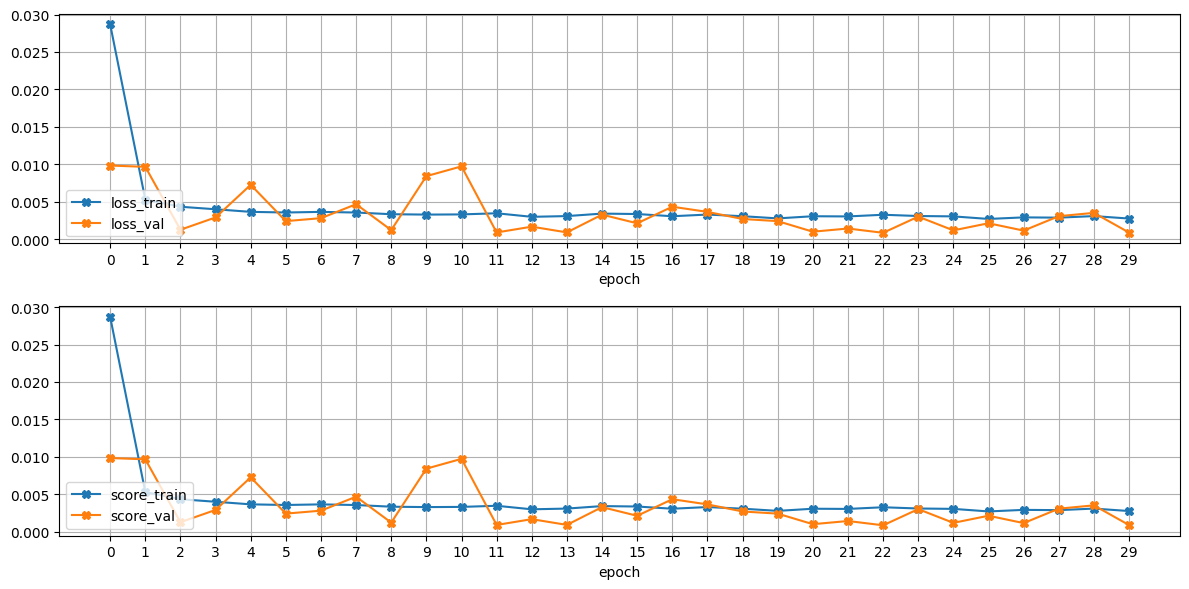

In [55]:
model = CNN().to(device)

score_function = torchmetrics.MeanAbsoluteError()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
criterion = nn.L1Loss()

pp = train(
    model,
    metlin_8_25_train_loader,
    metlin_8_25_val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=30,
)

In [56]:
accuracy = pp.history_dict["loss_val"][-1]
print(f"MAE {accuracy:.5f}")

MAE 0.00091


In [57]:
test_loss, test_score = val_loop(metlin_8_25_test_loader, model, criterion, score_function, device)
print(f'{test_loss = }, {test_score = }')

test_loss = 0.00090995404570207, test_score = 0.0009099938324652612


Обратное преобразование Бокса-Кокса для тестирования на других наборах данных:

In [58]:
def inverse_boxcox(transformed_data, lambda_value):
    if lambda_value == 0:
        return np.exp(transformed_data)
    else:
        return (lambda_value * transformed_data + 1) ** (1 / lambda_value)

In [59]:
mae_bc = 0
for imgs, labels in metlin_8_25_test_loader:
        labels = labels.unsqueeze(1)
        pred = inverse_boxcox(model(imgs.to(device)), lambda_8_25)
        mae_bc += (criterion(pred, labels.to(device)))
print(mae_bc / len(metlin_8_25_test_loader))

tensor(787.1474, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [60]:
preds = []
mae_bc = 0
for imgs, labels in metlin_0_8_test_loader:
        labels = labels.unsqueeze(1)
        pred = inverse_boxcox(model(imgs.to(device)), lambda_8_25)
        mae_bc += criterion(pred, inverse_boxcox(labels.to(device), lambda_0_8))
print(mae_bc / len(metlin_0_8_test_loader))

tensor(535.6585, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [61]:
preds = []
mae_bc = 0
for imgs, labels in hilic_oxana_loader:
        labels = labels.unsqueeze(1)
        pred = inverse_boxcox(model(imgs.to(device)), lambda_8_25)
        mae_bc += criterion(pred, labels.to(device))
print(mae_bc / len(hilic_oxana_loader))

tensor(323.5517, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [62]:
preds = []
mae_bc = 0
for imgs, labels in hilic_loader:
        labels = labels.unsqueeze(1)
        pred = inverse_boxcox(model(imgs.to(device)), lambda_8_25)
        mae_bc += criterion(pred, labels.to(device))
print(mae_bc / len(hilic_loader))

tensor(498.8015, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


Сохраним веса обученной модели:

In [63]:
torch.save(model.state_dict(), 'model_weights_best.pth')

# Дообучение нейронной сети:

Дообучение будем производить на наборе данных metlin_0_8

In [64]:
model.eval()

CNN(
  (layers_stack): Sequential(
    (0): Conv1d(37, 300, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(300, 300, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): AvgPool1d(kernel_size=(177,), stride=(1,), padding=(0,))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=300, out_features=600, bias=True)
    (7): ReLU()
    (8): Linear(in_features=600, out_features=1, bias=True)
  )
)

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device is running on: ', device)

Device is running on:  cuda


In [66]:
from tqdm import tqdm
model.to(device)

score_function = torchmetrics.MeanAbsoluteError()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()

def train_model(model, num_epochs=1, lr=1e-3, data=metlin_0_8_train_loader):
    for epoch in range(num_epochs):
        for imgs, labels in tqdm(data):
            optimizer.zero_grad()  # Clean existing gradients
            outputs = model(imgs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()  # Backpropagate the gradients
            optimizer.step()
        print(f"\nEpoch {epoch} Loss {loss.item()}")

In [67]:
train_model(model, num_epochs=50, lr=0.0001, data=metlin_0_8_train_loader)

  0%|          | 0/91 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
 95%|█████████▍| 86/91 [00:00<00:00, 210.14it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 91/91 [00:00<00:00, 207.65it/s]



Epoch 0 Loss 14.187211337756832


100%|██████████| 91/91 [00:00<00:00, 205.42it/s]



Epoch 1 Loss 13.834062872567593


100%|██████████| 91/91 [00:00<00:00, 212.56it/s]



Epoch 2 Loss 13.36162753514436


100%|██████████| 91/91 [00:00<00:00, 209.59it/s]



Epoch 3 Loss 13.190054420913022


100%|██████████| 91/91 [00:00<00:00, 207.09it/s]



Epoch 4 Loss 11.555141908138275


100%|██████████| 91/91 [00:00<00:00, 208.54it/s]



Epoch 5 Loss 8.652795006749594


100%|██████████| 91/91 [00:00<00:00, 208.91it/s]



Epoch 6 Loss 1.9700877069697835


100%|██████████| 91/91 [00:00<00:00, 212.63it/s]



Epoch 7 Loss 0.33882869165643414


100%|██████████| 91/91 [00:00<00:00, 207.84it/s]



Epoch 8 Loss 0.5794626019132016


100%|██████████| 91/91 [00:00<00:00, 212.29it/s]



Epoch 9 Loss 0.4883072211366638


100%|██████████| 91/91 [00:00<00:00, 207.72it/s]



Epoch 10 Loss 0.9241855803548719


100%|██████████| 91/91 [00:00<00:00, 210.53it/s]



Epoch 11 Loss 0.5446825072499263


100%|██████████| 91/91 [00:00<00:00, 211.15it/s]



Epoch 12 Loss 0.8112164530372014


100%|██████████| 91/91 [00:00<00:00, 210.87it/s]



Epoch 13 Loss 0.702623320996602


100%|██████████| 91/91 [00:00<00:00, 200.51it/s]



Epoch 14 Loss 0.7755380957742412


100%|██████████| 91/91 [00:00<00:00, 199.93it/s]



Epoch 15 Loss 3.556247011689482


100%|██████████| 91/91 [00:00<00:00, 196.34it/s]



Epoch 16 Loss 0.3532047463801968


100%|██████████| 91/91 [00:00<00:00, 193.39it/s]



Epoch 17 Loss 0.46187945797934554


100%|██████████| 91/91 [00:00<00:00, 199.30it/s]



Epoch 18 Loss 0.6858990282310318


100%|██████████| 91/91 [00:00<00:00, 155.79it/s]



Epoch 19 Loss 0.9215453235765321


100%|██████████| 91/91 [00:00<00:00, 197.96it/s]



Epoch 20 Loss 0.8734280714164542


100%|██████████| 91/91 [00:00<00:00, 187.59it/s]



Epoch 21 Loss 1.6686323596390038


100%|██████████| 91/91 [00:00<00:00, 212.57it/s]



Epoch 22 Loss 0.3019468784424976


100%|██████████| 91/91 [00:00<00:00, 207.38it/s]



Epoch 23 Loss 0.3946203614390691


100%|██████████| 91/91 [00:00<00:00, 211.38it/s]



Epoch 24 Loss 0.4420863262065752


100%|██████████| 91/91 [00:00<00:00, 207.94it/s]



Epoch 25 Loss 0.3474511132878508


100%|██████████| 91/91 [00:00<00:00, 207.34it/s]



Epoch 26 Loss 0.6114640809374026


100%|██████████| 91/91 [00:00<00:00, 202.65it/s]



Epoch 27 Loss 0.3436819220681318


100%|██████████| 91/91 [00:00<00:00, 158.68it/s]



Epoch 28 Loss 0.2992463340965005


100%|██████████| 91/91 [00:00<00:00, 167.85it/s]



Epoch 29 Loss 3.1646650090069515


100%|██████████| 91/91 [00:00<00:00, 135.11it/s]



Epoch 30 Loss 0.5510981594325578


100%|██████████| 91/91 [00:00<00:00, 139.57it/s]



Epoch 31 Loss 0.3443254063811704


100%|██████████| 91/91 [00:00<00:00, 107.43it/s]



Epoch 32 Loss 0.2578344146356801


100%|██████████| 91/91 [00:00<00:00, 114.42it/s]



Epoch 33 Loss 0.3838527168896241


100%|██████████| 91/91 [00:00<00:00, 149.20it/s]



Epoch 34 Loss 0.23648760145234138


100%|██████████| 91/91 [00:00<00:00, 146.68it/s]



Epoch 35 Loss 0.6718179411360815


100%|██████████| 91/91 [00:00<00:00, 213.58it/s]



Epoch 36 Loss 0.27874926708935965


100%|██████████| 91/91 [00:00<00:00, 209.14it/s]



Epoch 37 Loss 0.40397667055452224


100%|██████████| 91/91 [00:00<00:00, 209.24it/s]



Epoch 38 Loss 0.402652669862919


100%|██████████| 91/91 [00:00<00:00, 208.48it/s]



Epoch 39 Loss 0.5219206301974628


100%|██████████| 91/91 [00:00<00:00, 195.74it/s]



Epoch 40 Loss 0.30382384286233177


100%|██████████| 91/91 [00:00<00:00, 200.36it/s]



Epoch 41 Loss 0.5573748428054985


100%|██████████| 91/91 [00:00<00:00, 203.08it/s]



Epoch 42 Loss 0.6648849590679577


100%|██████████| 91/91 [00:00<00:00, 196.09it/s]



Epoch 43 Loss 0.5066417728522031


100%|██████████| 91/91 [00:00<00:00, 191.53it/s]



Epoch 44 Loss 0.3298044311045491


100%|██████████| 91/91 [00:00<00:00, 194.40it/s]



Epoch 45 Loss 0.5754340184802695


100%|██████████| 91/91 [00:00<00:00, 203.31it/s]



Epoch 46 Loss 0.22180998954986395


100%|██████████| 91/91 [00:00<00:00, 198.13it/s]



Epoch 47 Loss 0.6628092878777084


100%|██████████| 91/91 [00:00<00:00, 209.73it/s]



Epoch 48 Loss 0.5720191747549196


100%|██████████| 91/91 [00:00<00:00, 208.71it/s]


Epoch 49 Loss 0.4992390331649532


In [68]:
torch.save(model.state_dict(), 'model_weights_after_tuning.pth')

In [69]:
test_loss, test_score = val_loop(metlin_0_8_test_loader, model, criterion, score_function, device)
print(f'{test_loss = }, {test_score = }')

test_loss = 0.7483477113376851, test_score = 0.7483476400375366


In [70]:
preds_hilic = []
mae_bc = 0
for imgs, labels in hilic_loader:
        labels = labels.unsqueeze(1)
        pred = inverse_boxcox(model(imgs.to(device)), lambda_0_8)
        preds_hilic.append(pred)
        mae_bc += criterion(pred, labels.to(device))
print(mae_bc / len(hilic_loader))

tensor(149.3044, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [71]:
preds_hilic

[tensor([[89.7401],
         [89.1819],
         [89.1734],
         [89.5148],
         [89.0990],
         [89.8313],
         [89.4856],
         [90.1149],
         [89.2002],
         [89.1766],
         [89.1775],
         [89.0003],
         [89.5760],
         [89.0021],
         [89.9044],
         [88.8375]], device='cuda:0', grad_fn=<PowBackward0>),
 tensor([[89.3383],
         [90.1731],
         [89.5263],
         [88.3564],
         [88.7906],
         [89.2132],
         [89.3846],
         [89.9034],
         [90.4021],
         [89.6731],
         [89.1086],
         [88.8906],
         [89.1092],
         [87.9461],
         [90.2093],
         [89.1970]], device='cuda:0', grad_fn=<PowBackward0>),
 tensor([[88.5306],
         [89.6835],
         [88.9118],
         [87.7734],
         [88.8949],
         [89.2020],
         [88.3926],
         [88.5602],
         [89.0086],
         [89.6267],
         [89.4944],
         [89.4805],
         [90.8253],
         [90.3

In [72]:
hilic_array = [tensor.detach().cpu().numpy() for tensor in preds_hilic]
df_hilic = pd.DataFrame(np.concatenate(hilic_array, axis=0), columns=['Preds from CNN'])

In [73]:
df_hilic

,Preds from CNN
0,89.740089
1,89.181946
2,89.173416
3,89.514771
4,89.098961
...,...
875,90.390335
876,91.013260
877,88.527611
878,92.439064


In [74]:
hilic

,smiles,rt
0,C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O ...,121.144980
1,CC1C(NC(CN1)C2=CC=CC=C2)C ...,156.477000
2,C1CCC(C(C1)O)O ...,292.593000
3,C1CCC(=O)C(=O)C1 ...,346.336020
4,CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C ...,109.663980
...,...,...
875,CC1CC2=C(CCC(=O)C2)C3C1C4CCC(C4(CC3)C)(C#C)O ...,59.716998
876,C1=CC(=CC=C1C=CC2=CC(=CC(=C2)OC3C(C(C(C(O3)CO)...,278.401020
877,C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O...,583.062960
878,C1CC(=O)C(C=C1)(C(=O)OCC2=CC=CC=C2OC3C(C(C(C(O...,90.466980


In [75]:
hilic_to_XGB = pd.concat([hilic, df_hilic], axis=1)
hilic_to_XGB

,smiles,rt,Preds from CNN
0,C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O ...,121.144980,89.740089
1,CC1C(NC(CN1)C2=CC=CC=C2)C ...,156.477000,89.181946
2,C1CCC(C(C1)O)O ...,292.593000,89.173416
3,C1CCC(=O)C(=O)C1 ...,346.336020,89.514771
4,CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C ...,109.663980,89.098961
...,...,...,...
875,CC1CC2=C(CCC(=O)C2)C3C1C4CCC(C4(CC3)C)(C#C)O ...,59.716998,90.390335
876,C1=CC(=CC=C1C=CC2=CC(=CC(=C2)OC3C(C(C(C(O3)CO)...,278.401020,91.013260
877,C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O...,583.062960,88.527611
878,C1CC(=O)C(C=C1)(C(=O)OCC2=CC=CC=C2OC3C(C(C(C(O...,90.466980,92.439064


# Обучение XGBoost и RandomForest на наборе данных hilic, со столбцом предсказаний свёрточной нейронной сети

In [76]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Avalon import pyAvalonTools


def get_descriptors(data):
    molecules = data.smiles.apply(Chem.MolFromSmiles)
    morgan_generator = AllChem.GetMorganGenerator(radius=2)

    descriptor_list = []
    for mol in molecules:
        if mol is not None:
            morgan_fp = morgan_generator.GetFingerprint(mol)
            descriptor_list.append(morgan_fp.GetOnBits())
        else:
            descriptor_list.append([])

    data_descriptors = pd.DataFrame(descriptor_list)

    return data_descriptors.iloc[:, :-1]


In [77]:
xh_train = get_descriptors(hilic_to_XGB)

In [78]:
xh_train

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,7,80,301,314,371,389,549,650.0,807.0,834.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63,389,470,649,689,840,926,949.0,1019.0,1056.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,807,849,890,926,1019,1028,1041,1257.0,1304.0,1325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,310,314,650,751,926,1028,1380,1387.0,1711.0,1738.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18,314,322,400,504,564,650,758.0,771.0,801.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,85,225,231,314,441,449,455,519.0,529.0,555.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
876,25,80,167,222,322,392,466,489.0,524.0,584.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,80,192,222,253,295,486,489,610.0,650.0,656.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,80,145,147,203,222,277,296,314.0,352.0,379.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
xh_train = pd.DataFrame(xh_train)

In [80]:
xh_train = xh_train.iloc[:, :58]

In [81]:
Xh = xh_train.fillna(0)

In [82]:
Xh = pd.concat([Xh, hilic_to_XGB['Preds from CNN']], axis=1)

In [83]:
Xh.columns = range(59)

In [84]:
Xh

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,7,80,301,314,371,389,549,650.0,807.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.740089
1,63,389,470,649,689,840,926,949.0,1019.0,1056.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.181946
2,807,849,890,926,1019,1028,1041,1257.0,1304.0,1325.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.173416
3,310,314,650,751,926,1028,1380,1387.0,1711.0,1738.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.514771
4,18,314,322,400,504,564,650,758.0,771.0,801.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.098961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,85,225,231,314,441,449,455,519.0,529.0,555.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.390335
876,25,80,167,222,322,392,466,489.0,524.0,584.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.013260
877,80,192,222,253,295,486,489,610.0,650.0,656.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.527611
878,80,145,147,203,222,277,296,314.0,352.0,379.0,...,1600.0,1661.0,1678.0,1738.0,1750.0,1764.0,1844.0,1855.0,1873.0,92.439064


In [85]:
yh = hilic_to_XGB['rt']

In [86]:
yh

,rt
0,121.144980
1,156.477000
2,292.593000
3,346.336020
4,109.663980
...,...
875,59.716998
876,278.401020
877,583.062960
878,90.466980


### Стандартизация данных

In [87]:
yh = np.array(yh)

In [88]:
yh = yh.reshape(-1, 1)

In [89]:
for i in yh:
  if i == 0:
    print(i)

In [90]:
sc_h = StandardScaler()
yh_sc = sc_h.fit_transform(yh)

In [140]:
yh_sc

array([-0.63620679, -0.42186229,  0.40389625,  0.72993255, -0.70585719,
       -0.83492974, -0.80323162, -0.95192967,  0.11779017, -0.87314919,
       -0.77692717,  0.44357786,  0.95070739,  0.9924696 , -0.11887923,
        1.76873103,  0.76460888,  2.06243841,  1.99694993,  0.42369756,
       -0.7349462 , -0.42493185,  0.45631732,  0.71137464,  0.10797469,
       -0.55413799, -0.15692251,  0.28121181, -0.74118289,  2.22425229,
       -0.81525582,  0.63883048,  2.07765339, -0.90738872, -0.97828908,
       -0.62534737,  2.04713243, -0.92810621, -0.83478414, -0.3924577 ,
        1.96209124, -0.29322035, -0.86468631,  0.21722772, -1.00196075,
       -0.82103715,  1.79876679, -0.91375281,  0.58453484, -0.62534737,
        0.56725091, -0.46942439,  1.28085683,  0.48111774,  0.7405066 ,
       -0.49110028, -0.53548944,  1.65458846, -0.97966607,  1.60799677,
        1.37400309,  1.33085734,  1.56330476, -0.51945547,  1.22472265,
       -0.32783043, -0.83352836, -0.94184083,  1.30598448,  1.33

In [100]:
yh_sc = yh_sc.ravel()

In [139]:
yh_sc.shape

(880,)

Теперь создадим блендинг из моделей XGBoost и RandomFprest и подадим полученные значения как входные данные:

In [153]:
class BlendingRegressor:
    def __init__(self, first_layer_models, second_layer_model):
        self.first_layer_models = {
            name: sklearn.clone(model) for name, model in first_layer_models.items()
        }
        self.second_layer_model = sklearn.clone(second_layer_model)

    def fit_1st_layer(self, x, y):
        for name, model in self.first_layer_models.items():
            print(f"Fitting {name}")
            model.fit(x, y)

    def predict_1st_layer(self, x):
        features = np.zeros((x.shape[0], len(self.first_layer_models)))
        for ind, model in enumerate(self.first_layer_models.values()):
            features[:, ind] = model.predict(x).ravel()
        return features

    def fit_2nd_layer(self, x, y):
        features = self.predict_1st_layer(x)
        self.second_layer_model.fit(features, y)

    def predict(self, x):
        features = self.predict_1st_layer(x)
        y_pred = self.second_layer_model.predict(features)
        return y_pred

In [154]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


first_layer_models = {}

first_layer_models["XGB"] = xgboost.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    min_child_weight=13,
    n_jobs=-1,
    objective="reg:absoluteerror",
)

first_layer_models["RF"] = RandomForestRegressor(
    n_estimators=250, max_depth=None, min_samples_leaf=1, n_jobs=-1, random_state=42
)

In [155]:
x_learn, x_valid, y_learn, y_valid = train_test_split(Xh, yh_sc, random_state=42)
blend_reg = BlendingRegressor(first_layer_models, LinearRegression())

blend_reg.fit_1st_layer(x_learn, y_learn)

Fitting XGB
Fitting RF


In [156]:
blend_reg.fit_2nd_layer(x_valid, y_valid)

## Проверка работы на наборе данных `hilic_oxana.csv`:

Набор данных `hilic_oxana.csv` был получен опытным путём в лаборатории. Необходимо было проверить гипотезу о связи между различными предсказанными значениями из наборов данных, полученных в разных лабораториях при разных условиях проведения опытов.

In [157]:
ho_data = get_descriptors(hilic_oxana)
ho_label = hilic_oxana['rt']

In [158]:
ho_data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,378,433,489,609,695,713,1020.0,1114.0,1421.0,1603.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,74,242,378,409,697,1090,1104.0,1114.0,1171.0,1380.0,...,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,281,378,645,932,935,1036,1171.0,1438.0,1698.0,1800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,74,126,134,319,378,489,609.0,838.0,1057.0,1114.0,...,1873.0,1967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42,346,378,609,650,1104,1114.0,1866.0,1873.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,74,126,182,378,489,609,697.0,1114.0,1171.0,1311.0,...,1873.0,1967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,378,527,609,695,716,1088,1114.0,1312.0,1506.0,1628.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,74,315,378,552,609,678,1057.0,1114.0,1380.0,1387.0,...,1873.0,1883.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,62,201,378,587,935,1057,1084.0,1101.0,1145.0,1171.0,...,1762.0,1873.0,1956.0,2042.0,NaN,NaN,NaN,NaN,NaN,NaN
9,62,74,80,294,378,463,875.0,892.0,1057.0,1114.0,...,1380.0,1451.0,1457.0,1615.0,1799.0,1873.0,2004.0,NaN,NaN,NaN


In [159]:
zeros_to_add = np.zeros((19, 36))
ho_data = np.hstack((ho_data, zeros_to_add))

In [160]:
ho_data = pd.DataFrame(ho_data)
ho_data = ho_data.iloc[:, :59]
ho_data = ho_data.fillna(0)
ho_data = pd.DataFrame(ho_data)
ho_data

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,378.0,433.0,489.0,609.0,695.0,713.0,1020.0,1114.0,1421.0,1603.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,74.0,242.0,378.0,409.0,697.0,1090.0,1104.0,1114.0,1171.0,1380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,281.0,378.0,645.0,932.0,935.0,1036.0,1171.0,1438.0,1698.0,1800.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,74.0,126.0,134.0,319.0,378.0,489.0,609.0,838.0,1057.0,1114.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42.0,346.0,378.0,609.0,650.0,1104.0,1114.0,1866.0,1873.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,74.0,126.0,182.0,378.0,489.0,609.0,697.0,1114.0,1171.0,1311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,378.0,527.0,609.0,695.0,716.0,1088.0,1114.0,1312.0,1506.0,1628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,74.0,315.0,378.0,552.0,609.0,678.0,1057.0,1114.0,1380.0,1387.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,62.0,201.0,378.0,587.0,935.0,1057.0,1084.0,1101.0,1145.0,1171.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,62.0,74.0,80.0,294.0,378.0,463.0,875.0,892.0,1057.0,1114.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
ho_label

,rt
0,276.0
1,456.0
2,408.0
3,312.0
4,204.0
5,336.0
6,204.0
7,210.0
8,270.0
9,258.0


In [162]:
def print_metrics(y_true, y_predicted):
    print(f"Mean absolute error: {mean_absolute_error(y_true, y_predicted):.3f}")
    print(f"Mean squared error: {mean_squared_error(y_true, y_predicted):.3f}")
    print(f"Root mean squared error: {mean_squared_error(y_true, y_predicted, squared=False):.3f}")

In [165]:
y_pred = sc_h.inverse_transform(blend_reg.predict(ho_data).reshape(-1,1))

In [168]:
y_pred = np.squeeze(y_pred)
y_pred

array([361.90580489, 377.11591603, 325.10721472, 316.06956719,
       350.51210793, 311.33209629, 351.99552052, 358.99843451,
       404.89112242, 383.07693405, 345.42722582, 313.15983399,
       300.81737119, 387.32166845, 355.70127635, 359.94092355,
       314.93627073, 302.61026222, 304.80280523])

In [167]:
print_metrics(y_pred, ho_label)

Mean absolute error: 144.414
Mean squared error: 45535.054
Root mean squared error: 213.389


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Вывод:

Предсказания нейронной сети и использование ансамбля из XGBoost и RandomForest помогли снизить ошибку Mean absolute error с 258.843 до 144.414.